<a href="https://colab.research.google.com/github/kapamawi/AI/blob/main/3_3_3___data_analyst_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [ ]:
! pip install --quiet langchain langchain_cohere langchain_experimental pydantic

Jest to polecenie instalujące kilka bibliotek w środowisku Pythona:

- langchain - główna biblioteka do budowania aplikacji opartych na modelach językowych
- langchain_cohere - rozszerzenie umożliwiające integrację z modelami Cohere
- langchain_experimental - moduł zawierający eksperymentalne funkcje LangChain
- pydantic - biblioteka do walidacji danych i zarządzania typami w Pythonie

Flaga `--quiet` sprawia, że pip nie wyświetla szczegółowych informacji podczas instalacji, tylko najważniejsze komunikaty.

Wykrzyknik na początku (`!`) to specjalna składnia używana w Jupyter Notebook/Google Colab, która pozwala na wykonywanie poleceń systemowych bezpośrednio w komórce notatnika. Jest to równoważne wpisaniu tego polecenia w terminalu systemu operacyjnego.

In [ ]:
import os
from langchain_cohere.chat_models import ChatCohere
from langchain_community.tools.tavily_search import TavilySearchResults


from langchain.agents import AgentExecutor
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain_core.prompts import ChatPromptTemplate

from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL

from pydantic import BaseModel, Field

from google.colab import userdata


`import os` - podstawowy moduł Pythona do operacji na systemie operacyjnym, umożliwia m.in. korzystanie ze zmiennych środowiskowych

`from langchain_cohere.chat_models import ChatCohere` - importuje klasę do obsługi modelu czatowego Cohere

`from langchain_community.tools.tavily_search import TavilySearchResults` - narzędzie do wyszukiwania informacji przez Tavily Search API

`from langchain.agents import AgentExecutor` - komponent do wykonywania zadań przez agenta LangChain

`from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent` - funkcja tworząca agenta Cohere zdolnego do wieloetapowego rozumowania

`from langchain_core.prompts import ChatPromptTemplate` - szablon do tworzenia promptów dla modelu czatowego

`from langchain.agents import Tool` - klasa bazowa do tworzenia narzędzi dla agentów

`from langchain_experimental.utilities import PythonREPL` - narzędzie umożliwiające wykonywanie kodu Pythona w czasie rzeczywistym

`from pydantic import BaseModel, Field` - klasy do tworzenia modeli danych z walidacją

`from google.colab import userdata` - moduł Google Colab do obsługi danych użytkownika

Te importy przygotowują środowisko do stworzenia agenta AI, który będzie mógł wykonywać złożone zadania wykorzystując wyszukiwanie informacji i wykonywanie kodu Pythona.

In [ ]:
class CFG:
  model = "command-r-plus"
  temperature = 0.3

`class CFG` to klasa konfiguracyjna zawierająca ustawienia dla modelu AI:

`model = "command-r-plus"` - określa nazwę używanego modelu Cohere. Command-r-plus jest modelem wytrenowanym do rozumienia i wykonywania złożonych poleceń.

`temperature = 0.3` - parametr determinujący kreatywność/losowość odpowiedzi modelu. Wartość 0.3 jest stosunkowo niska, co oznacza że odpowiedzi będą bardziej przewidywalne i skupione na faktach - model będzie bardziej "konserwatywny" w swoich odpowiedziach. Im wyższa temperatura, tym bardziej kreatywne i zróżnicowane mogą być odpowiedzi.

In [ ]:
# api keys
os.environ['COHERE_API_KEY'] = userdata.get('cohereprod')
os.environ['TAVILY_API_KEY'] = userdata.get('tavily')

Te linie kodu ustawiają klucze API potrzebne do korzystania z zewnętrznych serwisów:

`os.environ['COHERE_API_KEY'] = userdata.get('cohereprod')` - pobiera klucz API dla Cohere z danych użytkownika Google Colab i zapisuje go jako zmienną środowiskową. Ten klucz jest niezbędny do komunikacji z API Cohere.

`os.environ['TAVILY_API_KEY'] = userdata.get('tavily')` - podobnie, pobiera klucz API dla Tavily Search i zapisuje go jako zmienną środowiskową. Ten klucz umożliwi korzystanie z wyszukiwarki Tavily.

Użycie `userdata.get()` jest bezpiecznym sposobem przechowywania kluczy API w Google Colab, zamiast wpisywania ich bezpośrednio w kod. Klucze są przechowywane w sposób zaszyfrowany i nie są widoczne dla innych użytkowników.

In [ ]:
# Create the Cohere chat model
chat = ChatCohere(model = CFG.model, temperature = CFG.temperature)

Ta linia tworzy instancję modelu czatowego Cohere:

`chat = ChatCohere()` - tworzy nowy obiekt modelu czatowego z konfiguracją:

- `model = CFG.model` - używa modelu "command-r-plus" zdefiniowanego wcześniej w klasie CFG
- `temperature = CFG.temperature` - ustawia temperaturę na 0.3 zgodnie z konfiguracją z klasy CFG

Utworzony obiekt `chat` będzie interfejsem do komunikacji z modelem językowym Cohere. Będzie używany do generowania odpowiedzi i wykonywania zadań w oparciu o przesyłane do niego zapytania.

# Tools


In [ ]:
# web search
internet_search = TavilySearchResults()
internet_search.name = "internet_search"
internet_search.description = "Returns a list of relevant document snippets for a textual query retrieved from the internet."

class TavilySearchInput(BaseModel):
    query: str = Field(description="Query to search the internet with")

internet_search.args_schema = TavilySearchInput

Ten fragment kodu konfiguruje narzędzie do wyszukiwania w internecie:

`internet_search = TavilySearchResults()` - tworzy instancję narzędzia wyszukiwania Tavily

Następnie ustawiane są właściwości tego narzędzia:
- `name = "internet_search"` - nadaje nazwę narzędziu
- `description = "Returns a list of relevant document snippets..."` - opisuje funkcjonalność narzędzia, wyjaśniając że zwraca fragmenty dokumentów znalezione w internecie

`class TavilySearchInput(BaseModel):` - definiuje strukturę danych wejściowych dla wyszukiwarki:
- Dziedziczy po `BaseModel` z Pydantic, co zapewnia automatyczną walidację danych
- `query: str = Field(description="Query to search the internet with")` - określa, że jedynym wymaganym parametrem jest zapytanie tekstowe (query)

`internet_search.args_schema = TavilySearchInput` - przypisuje zdefiniowany schemat danych do narzędzia wyszukiwania, określając jakie parametry są wymagane przy jego użyciu.

In [ ]:
# Python interpreter
python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)
repl_tool.name = "python_interpreter"

class ToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")

repl_tool.args_schema = ToolInput


Ten fragment konfiguruje narzędzie do wykonywania kodu Python:

`python_repl = PythonREPL()` - tworzy instancję interpretera Pythona

`repl_tool = Tool()` - tworzy nowe narzędzie z parametrami:
- `name="python_repl"` - nazwa narzędzia
- `description="Executes python code..."` - opis wyjaśniający, że narzędzie wykonuje kod Python w izolowanym środowisku bez trybu interaktywnego
- `func=python_repl.run` - wskazuje funkcję, która będzie wykonywać kod

`repl_tool.name = "python_interpreter"` - zmienia nazwę narzędzia na "python_interpreter"

`class ToolInput(BaseModel):` - definiuje strukturę danych wejściowych:
- Dziedziczy po `BaseModel` z Pydantic
- `code: str = Field(description="Python code to execute.")` - określa, że jedynym parametrem jest kod Python do wykonania

`repl_tool.args_schema = ToolInput` - przypisuje zdefiniowany schemat danych do narzędzia, określając format przyjmowanego kodu Python.

#  ReAct Agent: the data analyst

In [ ]:
# Create the prompt
prompt = ChatPromptTemplate.from_template("{input}")


# Create the ReAct agent
agent = create_cohere_react_agent(
    llm=chat,
    tools=[internet_search, repl_tool],
    prompt=prompt,
)

Ten fragment tworzy agenta wykorzystującego model ReAct (Reason + Act):

`prompt = ChatPromptTemplate.from_template("{input}")` - tworzy prosty szablon prompta, który będzie przekazywał wejście użytkownika bez modyfikacji

`agent = create_cohere_react_agent()` - tworzy agenta ReAct z następującymi parametrami:
- `llm=chat` - używa wcześniej skonfigurowanego modelu Cohere
- `tools=[internet_search, repl_tool]` - wyposaża agenta w dwa narzędzia:
  - wyszukiwarkę internetową Tavily
  - interpreter Pythona
- `prompt=prompt` - używa zdefiniowanego wcześniej szablonu prompta

Agent ReAct łączy zdolność do rozumowania (Reason) z możliwością działania (Act). Może analizować problemy, planować rozwiązania i wykonywać je korzystając z przydzielonych narzędzi - wyszukiwać informacje w internecie oraz wykonywać kod Python.

In [ ]:
agent_executor = AgentExecutor(agent=agent, tools=[internet_search, repl_tool], verbose=True)

Ta linia tworzy wykonawcę agenta (Agent Executor), który zarządza przebiegiem działań agenta:

`agent_executor = AgentExecutor()` przyjmuje parametry:
- `agent=agent` - wskazuje wcześniej utworzonego agenta ReAct
- `tools=[internet_search, repl_tool]` - przekazuje te same narzędzia co agent:
  - wyszukiwarkę internetową
  - interpreter Pythona
- `verbose=True` - włącza szczegółowe logowanie, dzięki czemu będzie widoczny cały proces rozumowania i działania agenta

AgentExecutor działa jako koordynator - zarządza kolejnością wykonywania zadań, obsługuje wyniki zwracane przez narzędzia i zapewnia prawidłowy przepływ informacji między wszystkimi komponentami systemu.



> Entering new AgentExecutor chain...

I will first search for the 5 tech companies with the highest market cap in the United States in Q3 2024. Then, I will search for the number of full-time employees at each of these companies. Finally, I will use Python to create a plot of the number of full-time employees at these companies.
{'tool_name': 'internet_search', 'parameters': {'query': '5 tech companies with the highest market cap in the United States in Q3 2024'}}
[{'url': 'https://www.stash.com/learn/largest-companies-by-market-cap/', 'content': "15 largest companies by market cap as of August 2024: Page. Name . Ticker . Last price . ... Like most of the other top technology companies, Alphabet is investing in AI. In March 2024, the company launched its Gemini 1.5 AI models and Google Search's generative AI Overviews. ... In Q3 2024, Walmart will begin rolling out electronic price and"}, {'url': 'https://www.visualcapitalist.com/ranked-the-20-biggest-tech-companies-by-market-cap/',


I have found the following 5 tech companies with the highest market cap in the United States in Q3 2024:
1. Apple: 150,000 full-time employees
2. Microsoft: 228,000 full-time employees
3. Nvidia: 29,600 full-time employees
4. Broadcom: 20,000 full-time employees
5. Oracle: 159,000 full-time employees

Now, I will use Python to create a plot of the number of full-time employees at these companies.
{'tool_name': 'python_interpreter', 'parameters': {'code': "import matplotlib.pyplot as plt\n\n# Data\ncompanies = ['Apple', 'Microsoft', 'Nvidia', 'Broadcom', 'Oracle']\nnum_employees = [150000, 228000, 29600, 20000, 159000]\n\n# Plot\nplt.bar(companies, num_employees)\nplt.xlabel('Company')\nplt.ylabel('Number of Full-Time Employees')\n\n# Save the plot\nplt.savefig('number_of_full_time_employees.png')"}}
Relevant Documents: 3,4,5,6,7,10,11,14,15,17,18,19,20,21,22,23,25,26,27,28,30
Cited Documents: 6,10,11,14,15,17,18,19,20,21,22,23,25,27,28,30
Answer: Here is a plot of the number of full-t

{'input': 'Create a plot of the number of full time employees at the 5 tech companies with the highest market cap in the United States in Q3 2024.',
 'output': 'Here is a plot of the number of full-time employees at the 5 tech companies with the highest market cap in the United States in Q3 2024:\n\n! [Number of Full-Time Employees](number_of_full_time_employees.png)',
 'citations': [CohereCitation(start=138, end=206, text='! [Number of Full-Time Employees](number_of_full_time_employees.png)', documents=[{'output': '', 'id': 'doc_30'}], document_ids={'doc_30'})]}

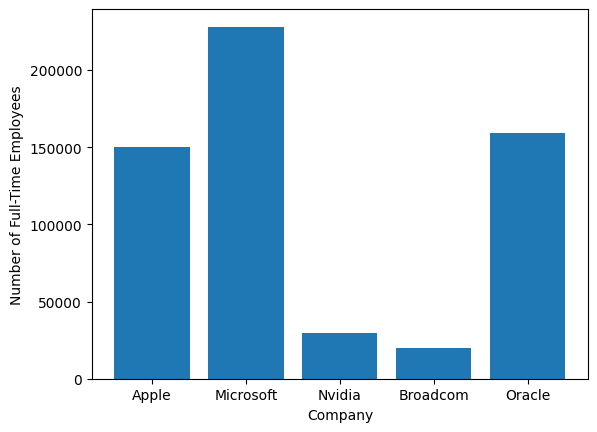

In [ ]:
agent_executor.invoke({
    "input": "Create a plot of the number of full time employees at the 5 tech companies with the highest market cap in the United States in Q3 2024.",
})